<a href="https://colab.research.google.com/github/istvanaut/colab_snippets/blob/master/pytorch_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim

In [116]:
train_data = datasets.FashionMNIST('data', download=True, train=True)
# we need FloatTensors as input
train_X = train_data.data.float()
train_y = train_data.targets
test_data = datasets.FashionMNIST('data', download=True, train=False)
test_X = test_data.data.float()
test_y = test_data.targets

Label: Trouser


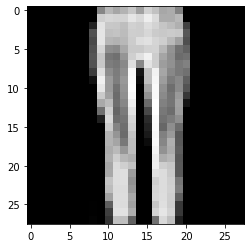

In [117]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

idx = np.random.randint(len(train_X))
sample_X = train_X[idx]
sample_y = train_y[idx]
print("Label: {}".format(labels[sample_y]))
plt.imshow(sample_X, 'gray')

In [118]:
train_X.size()

torch.Size([60000, 28, 28])

In [119]:
np.unique(train_y.numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [120]:
print("Before flattening:")
print("Train size:", train_X.size(), train_y.size())
print("Test size:", test_X.size(), test_y.size())

train_X = train_X.view(-1, 28 * 28).squeeze(1)
test_X = test_X.view(-1, 28 * 28).squeeze(1)

print("\nAfter flattening:")
print("Train size:", train_X.size(), train_y.size())
print("Test size:", test_X.size(), test_y.size())

Before flattening:
Train size: torch.Size([60000, 28, 28]) torch.Size([60000])
Test size: torch.Size([10000, 28, 28]) torch.Size([10000])

After flattening:
Train size: torch.Size([60000, 784]) torch.Size([60000])
Test size: torch.Size([10000, 784]) torch.Size([10000])


In [121]:
all_idx = np.arange(len(train_X))
np.random.shuffle(all_idx)
train_idx = all_idx[:50000]
dev_idx = all_idx[50000:]
print("The overlap between train and dev should be an empty set:", set(train_idx) & set(dev_idx))
print("")

dev_X = train_X[dev_idx]
dev_y = train_y[dev_idx]
train_X = train_X[train_idx]
train_y = train_y[train_idx]
print("Train size:", train_X.size(), train_y.size())
print("Dev size:", dev_X.size(), dev_y.size())
print("Test size:", test_X.size(), test_y.size())

The overlap between train and dev should be an empty set: set()

Train size: torch.Size([50000, 784]) torch.Size([50000])
Dev size: torch.Size([10000, 784]) torch.Size([10000])
Test size: torch.Size([10000, 784]) torch.Size([10000])


In [122]:
class BatchedIterator:
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
    
    def iterate_once(self):
        for start in range(0, len(self.X), self.batch_size):
            end = start + self.batch_size
            yield self.X[start:end], self.y[start:end]

In [123]:
train_iter = BatchedIterator(train_X, train_y, 33333)

for batch in train_iter.iterate_once():
    print(batch[0].size(), batch[1].size())

torch.Size([33333, 784]) torch.Size([33333])
torch.Size([16667, 784]) torch.Size([16667])


In [124]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, X):
        h = self.input_layer(X)
        h = self.relu(h)
        out = self.output_layer(h)
        return out

In [125]:
model = SimpleClassifier(
    input_dim=train_X.size(1),
    output_dim=10,
    hidden_dim=50
)
model

SimpleClassifier(
  (input_layer): Linear(in_features=784, out_features=50, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=50, out_features=10, bias=True)
)

In [126]:
for n, p in model.named_parameters():
    print(n, p.size())

input_layer.weight torch.Size([50, 784])
input_layer.bias torch.Size([50])
output_layer.weight torch.Size([10, 50])
output_layer.bias torch.Size([10])


In [127]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [128]:
test_pred = model(test_X).max(axis=1)[1]
print(torch.eq(test_pred, test_y).sum())

tensor(945)


In [129]:
batch_size = 1000
train_iter = BatchedIterator(train_X, train_y, batch_size)
dev_iter = BatchedIterator(dev_X, dev_y, batch_size)
test_iter = BatchedIterator(test_X, test_y, batch_size)

all_train_loss = []
all_dev_loss = []
all_train_acc = []
all_dev_acc = []

n_epochs = 10
for epoch in range(n_epochs):
    # training loop
    for bi, (batch_x, batch_y) in enumerate(train_iter.iterate_once()):
        
        y_out = model(batch_x)
        loss = criterion(y_out, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # one train epoch finished, evaluate on the train and the dev set (NOT the test)
    train_out = model(train_X)
    train_loss = criterion(train_out, train_y)
    all_train_loss.append(train_loss.item())
    train_pred = train_out.max(axis=1)[1]
    train_acc = torch.eq(train_pred, train_y).sum().float() / len(train_X)
    all_train_acc.append(train_acc)
    
    dev_out = model(dev_X)
    dev_loss = criterion(dev_out, dev_y)
    all_dev_loss.append(dev_loss.item())
    dev_pred = dev_out.max(axis=1)[1]
    dev_acc = torch.eq(dev_pred, dev_y).sum().float() / len(dev_X)
    all_dev_acc.append(dev_acc)
    
    print(f"Epoch: {epoch}\n  train accuracy: {train_acc}  train loss: {train_loss}")
    print(f"  dev accuracy: {dev_acc}  dev loss: {dev_loss}")

Epoch: 0
  train accuracy: 0.6520799994468689  train loss: 1.2815603017807007
  dev accuracy: 0.6532999873161316  dev loss: 1.2919070720672607
Epoch: 1
  train accuracy: 0.7110999822616577  train loss: 0.9573097825050354
  dev accuracy: 0.707099974155426  dev loss: 0.9731940627098083
Epoch: 2
  train accuracy: 0.7376199960708618  train loss: 0.8207024931907654
  dev accuracy: 0.7355999946594238  dev loss: 0.8422945141792297
Epoch: 3
  train accuracy: 0.7643600106239319  train loss: 0.7324347496032715
  dev accuracy: 0.7613999843597412  dev loss: 0.7580204010009766
Epoch: 4
  train accuracy: 0.7838000059127808  train loss: 0.6558606028556824
  dev accuracy: 0.7793999910354614  dev loss: 0.6879537105560303
Epoch: 5
  train accuracy: 0.7967600226402283  train loss: 0.6044327616691589
  dev accuracy: 0.7907999753952026  dev loss: 0.6440246105194092
Epoch: 6
  train accuracy: 0.8093400001525879  train loss: 0.5584858059883118
  dev accuracy: 0.8019000291824341  dev loss: 0.6000319719314575


In [130]:
test_pred = model(test_X).max(axis=1)[1]
test_acc = torch.eq(test_pred, test_y).sum().float() / len(test_X)
test_acc

tensor(0.8108)

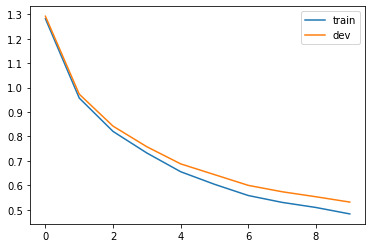

In [131]:
plt.plot(all_train_loss, label='train')
plt.plot(all_dev_loss, label='dev')
plt.legend()

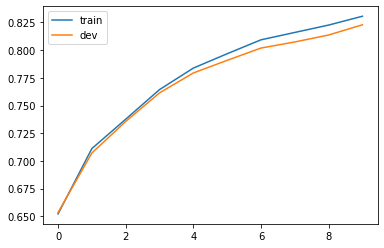

In [132]:
plt.plot(all_train_acc, label='train')
plt.plot(all_dev_acc, label='dev')
plt.legend()

In [133]:
toy_X = train_X[:5]
toy_y = train_y[:5]

model = SimpleClassifier(
    input_dim=train_X.size(1),
    output_dim=10,
    hidden_dim=500
)
optimizer = optim.Adam(model.parameters())

In [134]:
batch_size = 20
toy_train_iter = BatchedIterator(toy_X, toy_y, batch_size)

all_train_loss = []
all_dev_loss = []
all_train_acc = []
all_dev_acc = []

n_epochs = 20
for epoch in range(n_epochs):
    # training loop
    for bi, (batch_x, batch_y) in enumerate(toy_train_iter.iterate_once()):
        
        y_out = model(batch_x)
        loss = criterion(y_out, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # one train epoch finished, evaluate on the train and the dev set (NOT the test)
    train_out = model(toy_X)
    train_loss = criterion(train_out, toy_y)
    all_train_loss.append(train_loss.item())
    train_pred = train_out.max(axis=1)[1]
    train_acc = torch.eq(train_pred, toy_y).sum().float() / len(toy_X)
    all_train_acc.append(train_acc)
    
    dev_out = model(dev_X)
    dev_loss = criterion(dev_out, dev_y)
    all_dev_loss.append(dev_loss.item())
    dev_pred = dev_out.max(axis=1)[1]
    dev_acc = torch.eq(dev_pred, dev_y).sum().float() / len(dev_X)
    all_dev_acc.append(dev_acc)

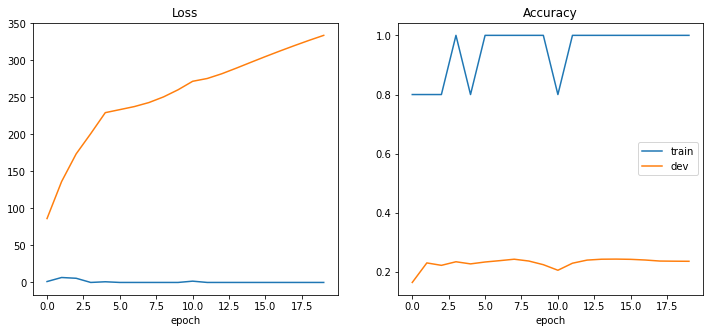

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")
ax[0].plot(all_train_loss, label='train')
ax[0].plot(all_dev_loss, label='dev')
ax[1].plot(all_train_acc, label='train')
ax[1].plot(all_dev_acc, label='dev')
plt.legend()

In [136]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

False
